In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from sympy import symbols, solve
from scipy.signal import argrelextrema

# Constantes
k_f, k_1, k_2, k_3, K_p = 28, 44, 26.5, 1.6, 0.18
R_1, r_2, R_3, r_4, R_5 = 6, 100, 50, 20, 1.6
V_p, J_leak = 1.2, 0.2

plt.rcParams.update({"font.size":20, "font.family":'Times New Roman'})

In [2]:
# Fonctions

def phi_1(c):
    """
        Calcul du taux phi_1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_1
    """
    return r_2 * c / (R_1 + c)
def phi_1_inv(c):
    """
        Calcul du taux phi_-1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_-1
    """
    return k_1 / (R_3 + c)
def phi_2(c):
    """
        Calcul du taux phi_2, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_2
    """
    return (k_2 + r_4*c) / (R_3 + c)
def phi_3(c):
    """
        Calcul du taux phi_3, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_3
    """
    return k_3 / (R_5 + c)

def J_pump(c):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
    Returns :
        J_Pump
    """
    return (V_p * c**2) / (K_p**2 + c**2)
def J_receptor(c,h,p,kf=k_f):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        kf : densité de récepteurs IP3 associé à chaque cellule
    Returns :
        J_Pump
    """
    return kf * ( (p*h*phi_1(c)) / (phi_1(c)*p + phi_1_inv(c)) )**4
def J_diffusion(c_1,c_2,D):
    """
        Calcul du taux de calcium diffusé entre deux cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
    Returns :
        J_Diffusion
    """
    return D*(c_2-c_1)

def J_diffusion2(c,interactions):
    """
        Calcul du taux de calcium diffusé entre plusieurs cellules
    Args :
        c : Concentration de calcium dans toutes les cellules (Matrice Nx1)
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
    Returns :
        J_Diffusion total pour chacune des cellules (Matrice Nx1)
    """
    return np.matmul(interactions,c)

def dc(c_1,c_2,h,p,D):
    """
        Équation différentielle du taux de variation de calcium pour un couplage de 2 cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        D : Force de diffusion entre deux cellules
    Returns :
        dc/dt
    """
    return J_receptor(c_1, h, p) - J_pump(c_1) + J_leak + J_diffusion(c_1, c_2, D)

def dh(c,h,p):
    """
        Équation différentielle d'ordre 1 décrivant la fraction de récepteurs InsP3 ouverts ou fermés.
    Args :
        c : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
    Returns :
        dh/dt
    """
    return phi_3(c) * (1-h) - (phi_1(c)*phi_2(c)*h*p) / (phi_1(c)*p + phi_1_inv(c))

def one_cell(t,hc,c_2,p,D):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans une cellule.
    Args :
        t : Variable d'évolution temporelle
        hc : couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second 
    Returns :
        Comportement du système au temps t
    """
    h, c = hc
    return [dh(c,h,p), dc(c,c_2,h,p,D)]

def three_cell(t,hc,c_2,c_3,p,D):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans 3 cellules.
    Args :
        t : Variable d'évolution temporelle
        hc : couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second 
    Returns :
        Comportement du système au temps t
    """
    h, c = hc
    return [dh(c,h,p),J_receptor(c, h, p) - J_pump(c) + J_leak + D*(c_3-c) + D*(c_2-c)]

def multiple_cells(t,hc,interactions,p,kf,func_c_infuse):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans plusieurs cellules.
    Args :
        t : Variable d'évolution temporelle
        hc : Couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        func_c_infuse : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        Comportement du système à plusieurs cellules au temps t
    """
    h = hc[:len(hc)//2]
    c = hc[len(hc)//2:]
    dh_val = dh(c,h,p)
    dc_val = J_receptor(c,h,p,kf) - J_pump(c) + J_leak + J_diffusion2(c,interactions) + np.array([c_mod(t) for c_mod in func_c_infuse])
    all_val = list(dh_val) + list(dc_val)
    return all_val

def fill_interactions_matrix(interactions):
    """
        Remplissage de la matrice d'interactions. Elle doit être symétrique et la diagonale est la somme des autres éléments de la même ligne (ou colonne)
    Args :
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN incomplète)
    Returns :
        Matrice d'interaction remplie
    """
    for n in range(0,interactions.shape[0]):
        for m in range(n+1,interactions.shape[0]):
            interactions[m,n] = interactions[n,m]
    for n in range(interactions.shape[0]):
        interactions[n,n] = -np.sum(interactions[n,:])
    return interactions

def graph_format_ax(ax):
    ax.tick_params(direction="in")
    

C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1994395925.py:48: RuntimeWarning: overflow encountered in scalar multiply
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1994395925.py:48: RuntimeWarning: overflow encountered in scalar power
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1994395925.py:48: RuntimeWarning: invalid value encountered in scalar divide
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1994395925.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return r_2 * c / (R_1 + c)
C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1994395925.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (k_2 + r_4*c) / (R_3 + c)


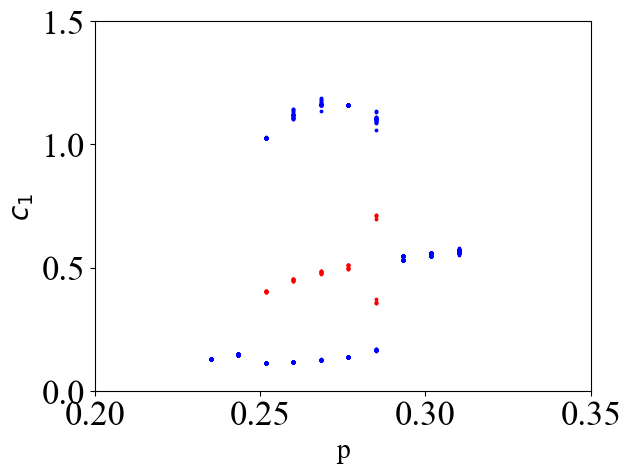

In [76]:
# Comportement d'une cellule avec c_2 constant
DIM_C = [0,1,1000]
DIM_H = [0,1,1000]
ps = [0.2,0.21,0.22,0.23,0.24,0.25,0.255,0.26,0.265,0.27,0.275,0.28,0.285,0.29,0.295,0.30,0.31,0.32]
ps = np.linspace(0.235,0.31,10)
Ds = [0.1]

c_1 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_1 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
c_2 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_2 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
c_2 = 0.1
H_1,C_1 = np.meshgrid(h_1,c_1)
t_span = [0,1000,10000]
t = np.linspace(t_span[0],t_span[1],t_span[2])
cycles_fixes = [] # (p,c)
cycles_fixes_instables = []
ch0 = [(0.53,0.6),(0.2,0.75)]
possible_c = np.linspace(0.1,0.6,1000)
possible_h = np.linspace(0.5,0.8,1000)
for _ in range(20):
    ch0.append((possible_h[np.random.randint(0,1000)],possible_c[np.random.randint(0,1000)]))
for p in  ps:
    for c_1_0, h_1_0 in ch0:
        sol = solve_ivp(one_cell,t_span[:2],[h_1_0,c_1_0],dense_output=True, args=[c_2,p,Ds[0]])
        sol_inv = solve_ivp(one_cell,[t_span[1], t_span[0]],[h_1_0,c_1_0],dense_output=True, args=[c_2,p,Ds[0]])
        h, c = sol.sol(t)
        h_inv, c_inv = sol_inv.sol(t)

        
        # print(f"Cycle fixe: p={p}, c={round(np.max(c[-100:]),3)}")
        cycles_fixes.append((p,np.max(c[-100:])))
        cycles_fixes.append((p,np.min(c[-100:])))
        cycles_fixes_instables.append((p,np.max(c_inv[:100])))
        # print(cycles_fixes_instables[-1])
        cycles_fixes_instables.append((p,np.min(c_inv[:100])))
        # print(cycles_fixes_instables[-1])

p_cycle, c_cycle = list(zip(*cycles_fixes))
p_cycle_instable, c_cycle_instable = list(zip(*cycles_fixes_instables))
plt.scatter(p_cycle, c_cycle,s=3,c="blue")
plt.scatter(p_cycle_instable, c_cycle_instable, s=3,c="red")
plt.xlim([0.2,0.35])
plt.ylim([0,1.5])
plt.ylabel("$c_1$")
plt.xlabel("p")
plt.show()


In [4]:
def general(t_span, c0, h0, p, kf, interactions, c_mod):
    """
        Solutionne, pour toutes les cellules, le comportement dans le temps en plus des injections
    Args :
        t_span : Informations sur le temps d'échatillonage [Début, fin, nombre d'itérations]
        c0 : Concentrations initiales de toutes les cellules
        h0 : Fraction des récepteurs ouverts ou fermés initial pour toutes les cellules
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        interactions : Matrice de la capacité d'échange entre toutes les cellules (Matrice NxN incomplète)
        c_mod : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        solution de l'équation différentielle
    """
    t = np.linspace(t_span[0], t_span[1],t_span[2])
    interactions = np.array(interactions)/100
    interactions = fill_interactions_matrix(interactions)
    initial_values = np.array(h0+c0)

    sol = solve_ivp(multiple_cells,t_span[:2],y0=initial_values,dense_output=True, args=[interactions,p,kf,c_mod],method="Radau").sol(t)
    return sol

def num_to_roman(n):
    """
        Converti un nombre format romain
    Args :
        n : Nombre à convertir
    Returns :
        Valeur de n en romain
    """
    # Ne devrait pas aller plus haut que 10 dans notre situation
    num = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X"]
    return num[n]

def graph_c_vs_t(sol, injections, N,t_span):
    """
        Trace le graphique de la concentration en fonction du temps de chacun des cellules
    Args :
        sol : Solution des équations différentielles de chacune des cellules
        injections : Liste des injections
        N : Nombre de cellules en jeu
    """
    colors = ["teal","darkviolet","black","red","green"]
    fig, ax = plt.subplots(N,1,figsize=(16,8),sharex=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    for n in range(N):
        last_injection_index = 0
        for injection in injections:
            indices = np.where((t>=injection[1]-injection[2]/2) & (t<=injection[1]+injection[2]/2))
            ax[n].plot(t[last_injection_index:indices[0][0]],sol[N+n][last_injection_index:indices[0][0]],alpha=1,color=colors[n%len(colors)])
            ax[n].plot(t[indices],sol[N+n][indices],alpha=1,linestyle="dashed",color=colors[n%len(colors)])
            last_injection_index = indices[0][-1]
        ax[n].plot(t[last_injection_index:],sol[N+n][last_injection_index:],alpha=1,color=colors[n%len(colors)],label=f"$c_{n+1}$")
        ymin, ymax = ax[n].get_ylim()
        xmin, xmax = ax[n].get_xlim()
        ax[n].set_xlim(0,t_span[1])
        ax[n].set_ylim(0,ymax)
        for num,injection in enumerate(injections):
            ax[n].fill_between(x=[injection[1]-injection[2]/2,injection[1]+injection[2]/2], y1=ymax,y2=0,alpha=0.5,color="grey")
            if n == 0: ax[n].text(injection[1],ymax,f"{num_to_roman(num)}",horizontalalignment='center',verticalalignment='bottom')
        graph_format_ax(ax[n])
        ax[n].legend(loc="upper right")
    plt.xlabel("Temps [s]")
    plt.ylabel("Concentration de Ca$^{2+}$ [$\mu M$]",loc="center")
    plt.show()

def graph_h_vs_t(sol, injections, N):
    """
        Trace le graphique de la concentration en fonction du temps de chacun des cellules
    Args :
        sol : Solution des équations différentielles de chacune des cellules
        injections : Liste des injections
        N : Nombre de cellules en jeu
    """
    colors = ["blue","orange","green","red","black"]
    fig, ax = plt.subplots(N,1,figsize=(16,8),sharex=True)
    plt.xlabel("Temps [s]")
    plt.ylabel("Concentration c")
    for n in range(N):
        last_injection_index = 0
        for injection in injections:
            indices = np.where((t>=injection[1]-injection[2]/2) & (t<=injection[1]+injection[2]/2))
            ax[n].plot(t[last_injection_index:indices[0][0]],sol[n][last_injection_index:indices[0][0]],alpha=1,color=colors[n%len(colors)])
            ax[n].plot(t[indices],sol[n][indices],alpha=1,linestyle="dashed",color=colors[n%len(colors)])
            last_injection_index = indices[0][-1]
        ax[n].plot(t[last_injection_index:],sol[n][last_injection_index:],alpha=1,color=colors[n%len(colors)],label=f"$c_{n+1}$")
        ymin, ymax = ax[n].get_ylim()
        ax[n].set_ylim(0,ymax)
        for num,injection in enumerate(injections):
            ax[n].fill_between(x=[injection[1]-injection[2]/2,injection[1]+injection[2]/2], y1=ymax,y2=0,alpha=0.5,color="grey")
            ax[n].text(injection[1],ymax,f"{num_to_roman(num)}",horizontalalignment='center',verticalalignment='bottom')
        graph_format_ax(ax[n])
        ax[n].legend(loc="upper right")
    
    plt.xlim([0,t_span[1]])
    plt.show()


def animate_c_vs_h(N, sol):
    """
        Animation c vs h pour toutes les cellules
    Args :
        N : Nombre de cellules en jeu
        sol : Solution des équations différentielles de chacune des cellules
    """
    fig, ax = plt.subplots(figsize=(16,8))
    for n in range(N):
        plt.plot(sol[n],sol[N+n],label=f"$c_{n+1}$, $h_{n+1}$")
    plt.legend()
    points = []
    for n in range(N):
        points.append(ax.plot(sol[n][0],sol[N+n][0], marker="o")[0])
    def update(x):
        for n,point in enumerate(points):
            point.set_data([sol[n][x]],[sol[N+n][x]])
        return points
    ani = FuncAnimation(fig, update, interval=0.1, blit=True, repeat=True,
                        frames=100)
    plt.show()
    # ani.save("animation.gif")

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\1879215350.py:68: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Concentration de Ca$^{2+}$ [$\mu M$]",loc="center")


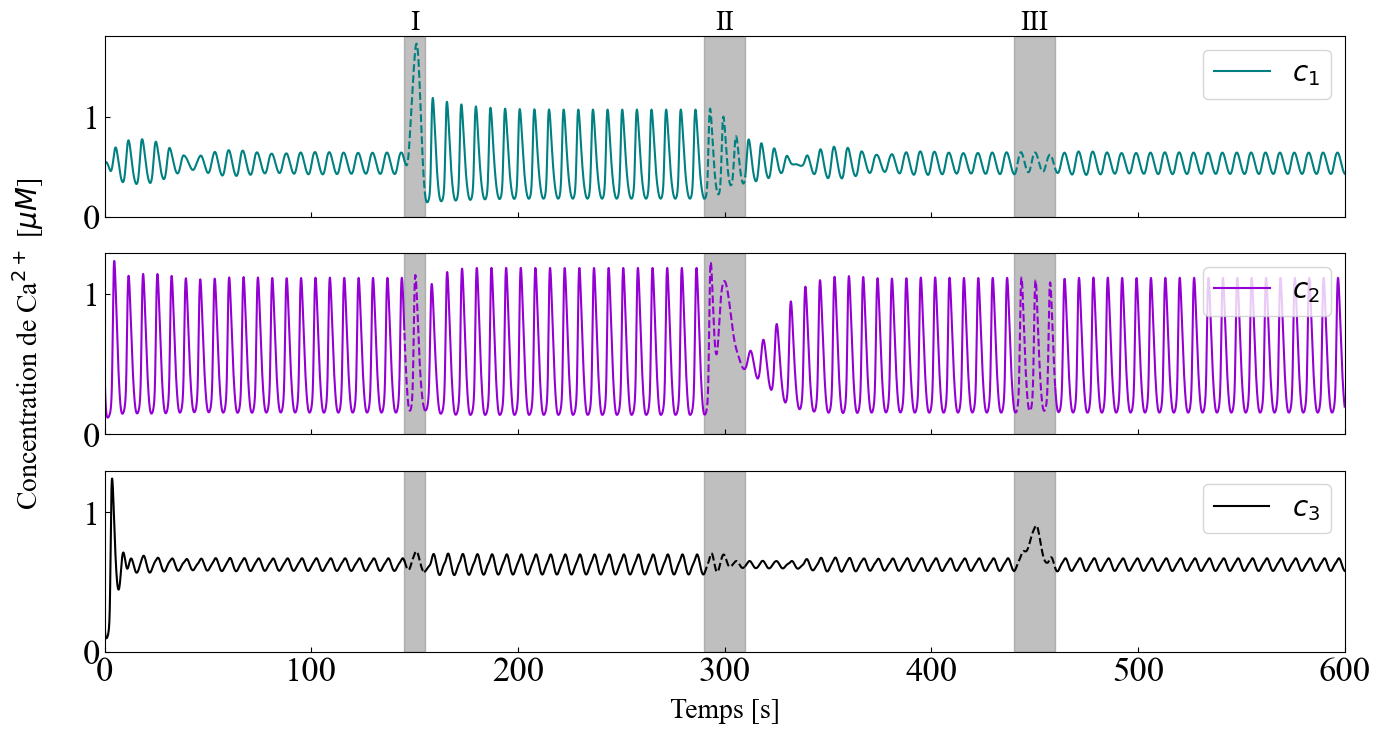

Cellule: 1
Max: 0.645, Min: 0.429, Amplitude: 0.11
Max: 1.074, Min: 0.183, Amplitude: 0.45
Max: 0.647, Min: 0.428, Amplitude: 0.11
Max: 0.644, Min: 0.43, Amplitude: 0.11
Cellule: 2
Max: 1.115, Min: 0.155, Amplitude: 0.48
Max: 1.185, Min: 0.138, Amplitude: 0.52
Max: 1.115, Min: 0.155, Amplitude: 0.48
Max: 1.115, Min: 0.155, Amplitude: 0.48
Cellule: 3
Max: 0.67, Min: 0.579, Amplitude: 0.05
Max: 0.698, Min: 0.554, Amplitude: 0.07
Max: 0.67, Min: 0.579, Amplitude: 0.05
Max: 0.67, Min: 0.58, Amplitude: 0.05


In [43]:

def injection_sin(t, positions, widths, amps):
    somme, valid = 0, False
    for pos, width,amp in zip(positions,widths,amps):
        if ((t >= pos - width/2) and (t <= pos + width/2)):
            valid = True
            somme += 0.5*amp*(np.sin(((2)*np.pi/width)*(t-pos) + (np.pi/2)) + 1)
    if valid: return somme
    else: return 0

def injection_gauss(t, positions, widths, amps):
    """
        Injection avec une évolution de type gaussienne
    Args :
        t : temps
        positions : Position des gaussiennes
        width : Valeur de référence pour sigma en plus de limiter le domaine de chacune des gaussiennes
        amps : Amplitude des gaussiennes
    Returns :
        Valeur de l'injection au temps t
    """
    
    somme, valid = 0, False
    for pos, width,amp in zip(positions,widths,amps):
        sigma = width / (2*np.sqrt(2*np.log(100)))
        if ((t >= pos - width/2) and (t <= pos + width/2)): valid = True
        somme += amp*np.exp(-0.5*((t-pos)/(sigma))**2)
    if valid: return somme
    else: return 0

def get_solution_N_cell(N, t_span,c0,h0,p,kf,interactions,injections,graph=True):
    # Analyse injections pour analyse automatique de c_mod
    c_mod_dict = {}
    for n in range(1,N+1):
        c_mod_dict[f"{n}"] = {"Positions":[],"Widths":[],"Amplitudes":[]}
    for injection in injections:
        n = injection[0].replace("$","").replace("c_","")
        c_mod_dict[n] = c_mod_dict.get(n,{"Positions":[],"Widths":[],"Amplitudes":[]})
        c_mod_dict[n]["Positions"].append(injection[1])
        c_mod_dict[n]["Widths"].append(injection[2])
        c_mod_dict[n]["Amplitudes"].append(injection[3])
    c_mod_list = sorted(c_mod_dict.items())
    c_mod = [lambda x,mod=mod: injection_gauss(x,mod["Positions"],mod["Widths"],mod["Amplitudes"]) for n,mod in c_mod_list]
    sol = general(t_span,c0,h0,p,kf,interactions,c_mod)
    t_span_inv = [t_span[1], t_span[0], t_span[2]]
    sol_inv = general(t_span_inv,c0,h0,p,kf,interactions,c_mod)
    # animate_c_vs_h(N,sol)
    if graph: graph_c_vs_t(sol, injections, N,t_span)
    return sol, sol_inv

# General perturbations
N = 3
t_span = [0,600,10000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]] # Les valeurs sont divisées par 100

c0 = [0.53,0.4, 0.2]
h0 = [0.6,0.5, 0.1]

p = np.array([0.27,0.26,0.33])
kf = np.array([28,28,28])

injections = [["$c_1$",150,10,1],["$c_2$",300,20,0.5],["$c_3$",450,20,0.3]] # [No. cellule, temps d'injection, durée de l'injection, amplitude injection] dans l'ordre chronologique
sol, sol_inv = get_solution_N_cell(N,t_span,c0,h0,p,kf,interactions,injections)

for n in range(len(injections)):
    # plt.figure(figsize=(16,8))
    # plt.plot(t,sol[N+n])
    print(f"Cellule: {n+1}")
    for name, pos, width, amp in injections:
        index = int((pos-width/2)*t_span[2]/t_span[1])
        index_range = int((pos-width/2 - 20)*t_span[2]/t_span[1])
        c_max, c_min = np.max(sol[N+n][index_range:index]), np.min(sol[N+n][index_range:index])
        print(f"Max: {round(c_max,3)}, Min: {round(c_min,3)}, Amplitude: {round((c_max-c_min)/2,2)}")
        # plt.hlines(y=[c_max,c_min], xmin=[pos-width/2 - 20,pos-width/2 - 20], xmax=[pos-width/2,pos-width/2], colors=["red","red"], linewidth=[2,2])
    index_range = int((width/2 + 20)*t_span[2]/t_span[1])
    c_max, c_min = np.max(sol[N+n][-index_range:]), np.min(sol[N+n][-index_range:])
    print(f"Max: {round(c_max,3)}, Min: {round(c_min,3)}, Amplitude: {round((c_max-c_min)/2,2)}")
    # plt.hlines(y=[c_max,c_min], xmin=[t_span[1]-width/2 - 20,t_span[1]-width/2 - 20], xmax=[t_span[1], t_span[1]], colors=["red","red"], linewidth=[2,2])
    # plt.show()




C:\Users\Zach Robitaille\AppData\Local\Temp\ipykernel_4792\3379110718.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A, b)[0].squeeze()


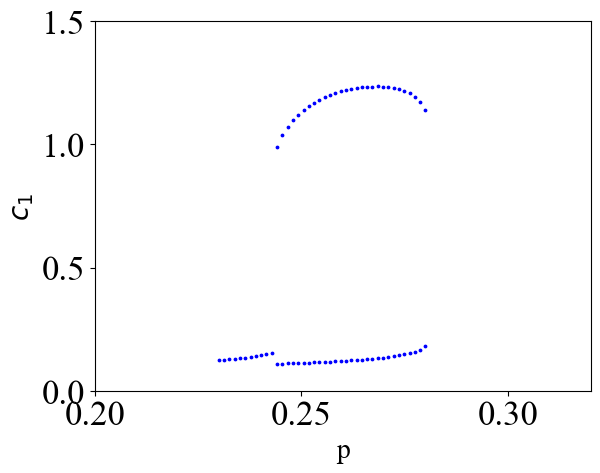

In [65]:
def fit_ellipse(pool,h,c):
    x = h[-pool:]
    y = c[-pool:]
    A = np.stack([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)
    w = np.linalg.lstsq(A, b)[0].squeeze()
    xlin = np.linspace(0, 1, 300)
    ylin = np.linspace(0, 1.5, 300)
    X, Y = np.meshgrid(xlin, ylin)

    Z = w[0]*X**2 + w[1]*X*Y + w[2]*Y**2 + w[3]*X + w[4]*Y

    # Define the variables
    x, y = symbols('x y')

    # Given coefficients
    a = w[0]
    b = w[1]
    c = w[2]
    d = w[3]
    e = w[4]

    # Given constant term
    z = 0  # Assuming the constant term is zero

    # Given ellipse equation in polynomial form
    ellipse_equation = a*x**2 + b*x*y + c*y**2 + d*x + e*y - z

    # Solve for x and y to find the center point
    solution = solve((ellipse_equation.diff(x), ellipse_equation.diff(y)), (x, y))

    # print(solution.items())
    # print(list(solution.items())[0][1], list(solution.items())[1][1])

    # Extract the center point
    center = list(solution.items())
    center_point = (center[0][1], center[1][1])

    # print("Center point of the ellipse:", center_point)

    return center_point


# P = np.linspace(0.24,0.25,8)
P = np.linspace(0.23,0.28,40)
N = 3
interactions = [[0,1,1],
                [0,0,1],
                [0,0,0]] # Les valeurs sont divisées par 100
t_span = [0,300,1000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
c0 = [0.6,0.6, 0.6]
h0 = [0.2,0.2, 0.2]
new_c0 = c0
new_h0 = h0
ch_0 = [(new_c0, new_h0)]
kf = np.array([28,28,28])

injections = []

bifurcation_points = []

stable_interval = 200

DEPTH = 1
for p in P:
    p = np.ones((N,))*p

    dep = 1
    new_ch_0 = ch_0
    while dep <= DEPTH:
        dep += 1
        ch_0 = []
        for c, h in new_ch_0:
            
            sol, sol_inv = get_solution_N_cell(N,t_span,c,h,p,kf,interactions,injections,graph=False)
            h, c = sol[0:N], sol[N:]
            h_max, h_min = np.max(h[0][-stable_interval:]), np.min(h[0][-stable_interval:])
            c_max, c_min = np.max(c[0][-stable_interval:]), np.min(c[0][-stable_interval:])
            h_inv, c_inv = sol_inv[0:N], sol_inv[N:]
            h_inv_max, h_inv_min = np.max(h_inv[0][-stable_interval:]), np.min(h_inv[0][-stable_interval:])
            c_inv_max, c_inv_min = np.max(c_inv[0][-stable_interval:]), np.min(c_inv[0][-stable_interval:])
            # plt.plot(t[-stable_interval:], c[0][-stable_interval:])
            # plt.plot(t, c[0])
            c_max_array = argrelextrema(c[0][-stable_interval:], np.greater)
            c_min_array = argrelextrema(c[0][-stable_interval:], np.less)
            # plt.scatter(t[-stable_interval:][c_max_array], c[0][-stable_interval:][c_max_array])
            # plt.scatter(t[-stable_interval:][c_min_array], c[0][-stable_interval:][c_min_array])
            # plt.plot(h[0][-stable_interval:],c[0][-stable_interval:], color="red")
            # plt.plot(h_inv[0][-stable_interval:], c_inv[0][-stable_interval:], color="green")
            # plt.plot(h[0],c[0], color="red")
            # plt.plot(h_inv[0], c_inv[0], color="green")
            # plt.text(0,1.2,f"p={round(p[0],4)}")
            # plt.xlim([0,1])
            # plt.ylim([0,1.3])

            if c_max/c_min > 1.01:
                bifurcation_points.append((p[0],np.max(c[0][-stable_interval:])))
                bifurcation_points.append((p[0],np.min(c[0][-stable_interval:])))
                ellipse_center = fit_ellipse(pool=stable_interval,h=h[0],c=c[0])
                new_h0 = list(np.ones((N,))*ellipse_center[0])
                new_c0 = list(np.ones((N,))*ellipse_center[1])
                ch_0.append((list(np.ones((N,))*ellipse_center[1]),list(np.ones((N,))*ellipse_center[0])))
                # plt.scatter(ellipse_center[0], ellipse_center[1],c=["red"],s=[3])
            else:
                bifurcation_points.append((p[0],c[0][-1]))
            if c_inv_max < 2 and c_inv_min >= 0 and c_inv_max/c_inv_min > 1.01:
                bifurcation_points.append((p[0],np.max(c_inv[0][-stable_interval:])))
                bifurcation_points.append((p[0],np.min(c_inv[0][-stable_interval:])))
                ellipse_center = fit_ellipse(pool=stable_interval,h=h_inv[0],c=c_inv[0])
                new_h0 = list(np.ones((N,))*ellipse_center[0])
                new_c0 = list(np.ones((N,))*ellipse_center[1])
                ch_0.append((list(np.ones((N,))*ellipse_center[1]),list(np.ones((N,))*ellipse_center[0])))
                # plt.scatter(ellipse_center[0], ellipse_center[1],c=["green"],s=[3])
            else:
                bifurcation_points.append((p[0],c_inv[0][-1]))
            # plt.show()
        new_ch_0 = ch_0
    new_c0 = c0
    new_h0 = h0
    ch_0 = [(new_c0,new_h0)]

bif_p, bif_c = list(zip(*bifurcation_points))
plt.scatter(bif_p, bif_c,s=3,c="blue")
plt.xlim([0.2,0.32])
plt.ylim([0,1.5])
plt.ylabel("$c_1$")
plt.xlabel("p")
plt.show()

3.295051144911304


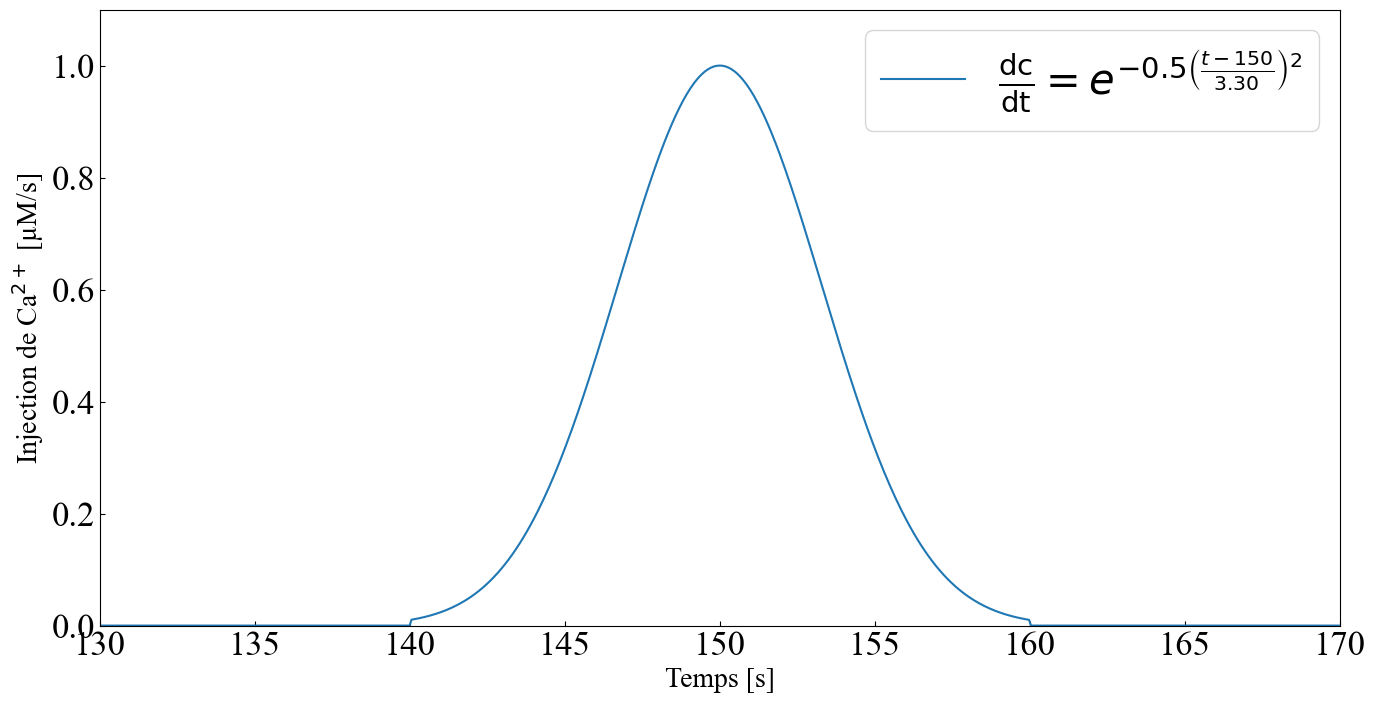

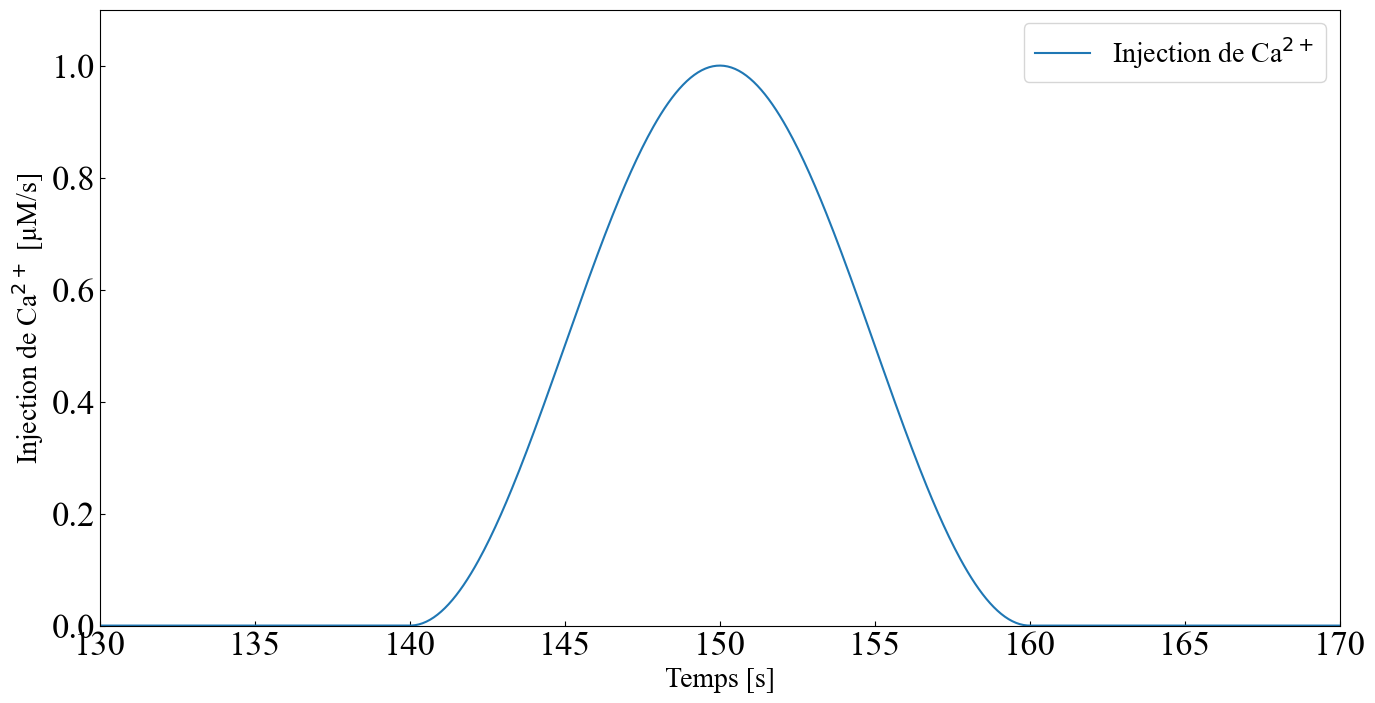

3.295051144911304


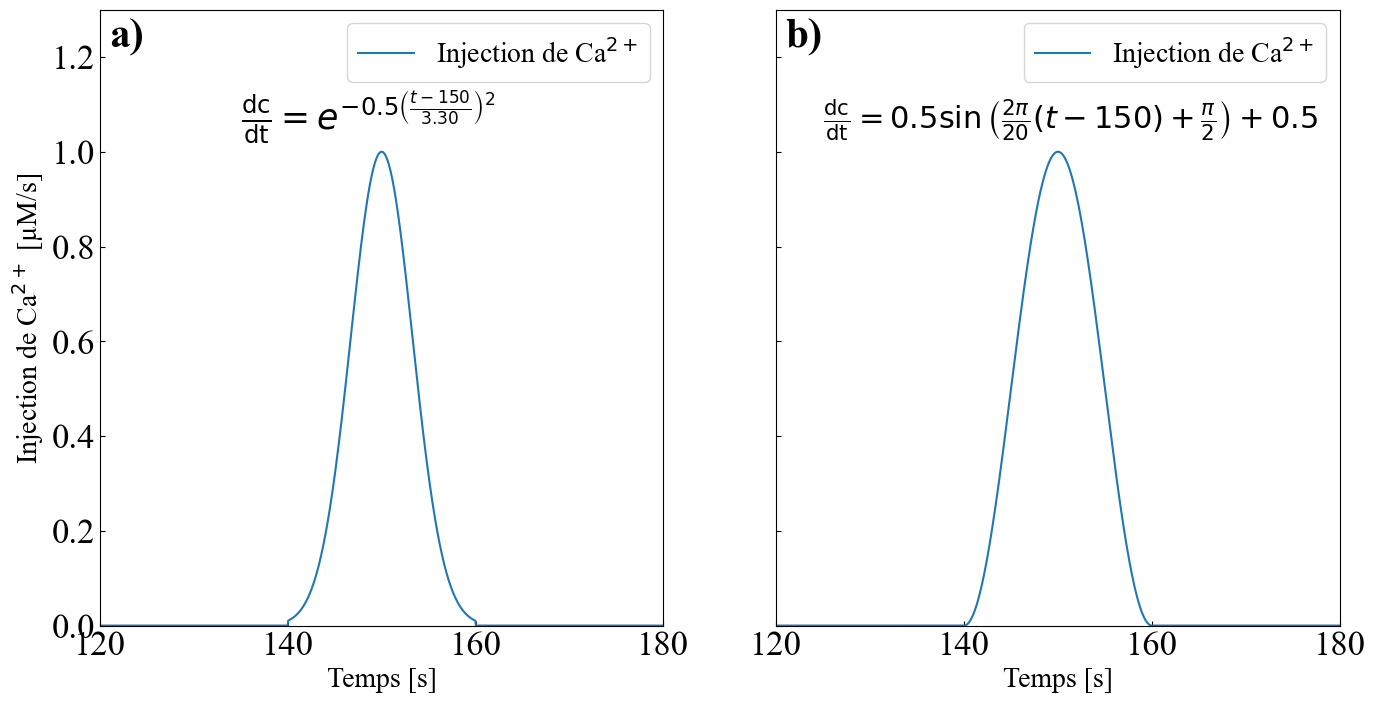

In [66]:
# Comparaison injection gaussienne et sinusoïdale

plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
injections = [["$c_1$",150,10,1],["$c_2$",300,20,0.5],["$c_3$",450,20,0.3]]
T = np.linspace(0,600,10000)
dc_dt = []
# La fonction d'injection ne soutien pas les arrays, seulement int et floats
for t in T:
    dc_dt.append(injection_gauss(t,positions=[150],widths=[20],amps=[1]))
sigma = 20 / (2*np.sqrt(2*np.log(100)))
print(sigma)
fig, ax = plt.subplots(1,1,figsize=(16,8))
graph_format_ax(ax)
ax.plot(T,dc_dt,label=f"$\\frac{{\\text{{dc}}}}{{\\text{{dt}}}}=e^{{-0.5\\left(\\frac{{t-150}}{{3.30}}\\right)^2}}$")
# ax.text(160,0.8,f"$\\frac{{\\text{{dc}}}}{{\\text{{dt}}}}=e^{{-0.5(\\frac{{t-150}}{{3.30}})^2}}$")
ax.set_xlabel("Temps [s]")
ax.set_ylabel("Injection de Ca$^{2+}$ [µM/s]")
ax.set_xlim(130,170)
ax.set_ylim(0,1.1)
ax.legend(prop={"size": 30})
plt.show()

dc_dt = []
# La fonction d'injection ne soutien pas les arrays, seulement int et floats
for t in T:
    dc_dt.append(injection_sin(t,positions=[150],widths=[20],amps=[1]))

fig, ax = plt.subplots(1,1,figsize=(16,8))
graph_format_ax(ax)
ax.plot(T,dc_dt,label="Injection de Ca$^{2+}$")
ax.set_xlabel("Temps [s]")
ax.set_ylabel("Injection de Ca$^{2+}$ [µM/s]")
ax.set_xlim(130,170)
ax.set_ylim(0,1.1)
ax.legend()
plt.show()


dc_dt = []
# La fonction d'injection ne soutien pas les arrays, seulement int et floats
for t in T:
    dc_dt.append(injection_gauss(t,positions=[150],widths=[20],amps=[1]))
sigma = 20 / (2*np.sqrt(2*np.log(100)))
print(sigma)
fig, ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
graph_format_ax(ax[0])
ax[0].plot(T,dc_dt,label="Injection de Ca$^{2+}$")
ax[0].text(135,1.05,f"$\\frac{{\\text{{dc}}}}{{\\text{{dt}}}}=e^{{-0.5\\left(\\frac{{t-150}}{{3.30}}\\right)^2}}$",size=25)
ax[0].text(121,1.22,f"a)", weight="bold", size=30)
# ax.text(160,0.8,f"$\\frac{{\\text{{dc}}}}{{\\text{{dt}}}}=e^{{-0.5(\\frac{{t-150}}{{3.30}})^2}}$")
ax[0].set_xlabel("Temps [s]")
ax[0].set_ylabel("Injection de Ca$^{2+}$ [µM/s]")
ax[0].set_xlim(120,180)
ax[0].set_ylim(0,1.3)
ax[0].legend(loc="upper right")


dc_dt = []
# La fonction d'injection ne soutien pas les arrays, seulement int et floats
for t in T:
    dc_dt.append(injection_sin(t,positions=[150],widths=[20],amps=[1]))

graph_format_ax(ax[1])
ax[1].plot(T,dc_dt,label="Injection de Ca$^{2+}$")
ax[1].text(125,1.05,"$\\frac{\\text{dc}}{\\text{dt}}=0.5\\sin\\left(\\frac{2\\pi}{20}(t-150) + \\frac{\\pi}{2}\\right) + 0.5$",size=22)
ax[1].text(121,1.22,f"b)", weight="bold", size=30)
ax[1].set_xlabel("Temps [s]")
# ax[1].set_ylabel("Injection de Ca$^{2+}$ [µM/s]")
ax[1].set_xlim(120,180)
ax[1].set_ylim(0,1.3)
ax[1].legend(loc="upper right")
# plt.xlabel("Temps [s]", loc="left")
plt.show()


